# **Plant Pathology Analysis with transfer learning(DenseNet 169)**
* *Data Visualization*
* *Data Augmentation*
* *Model training: DenseNet 169*
* *Prediction*
* *Submission*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
import seaborn as sns

In [2]:
df=pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")
df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


# *Data Visualization*

<AxesSubplot:xlabel='labels', ylabel='count'>

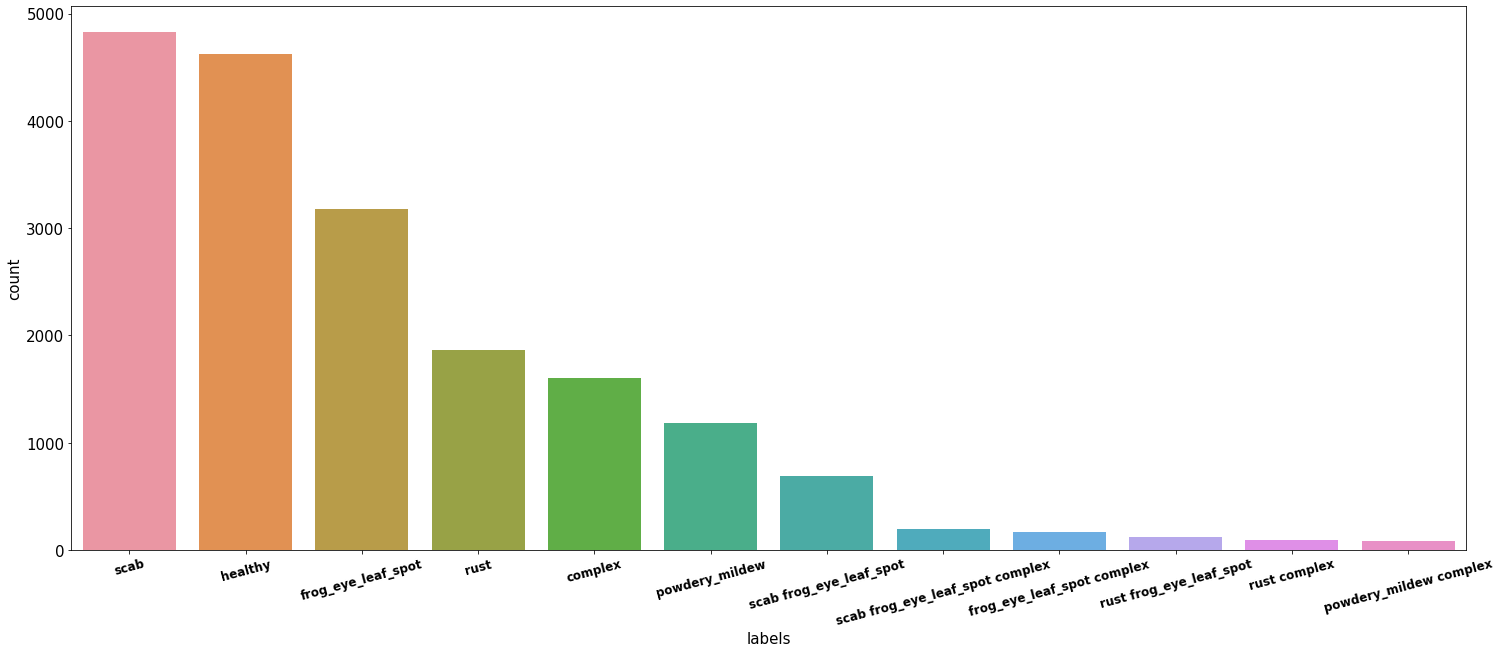

In [3]:
plt.figure(figsize=(25,10))
plt.xlabel("labels",fontsize=15)
plt.xticks(rotation=15,fontsize = 12,fontweight = "bold")
plt.ylabel("count",fontsize=15)
plt.yticks(fontsize=15)
sns.barplot(data=df,x=df.value_counts("labels").index,y=df.value_counts("labels").values)

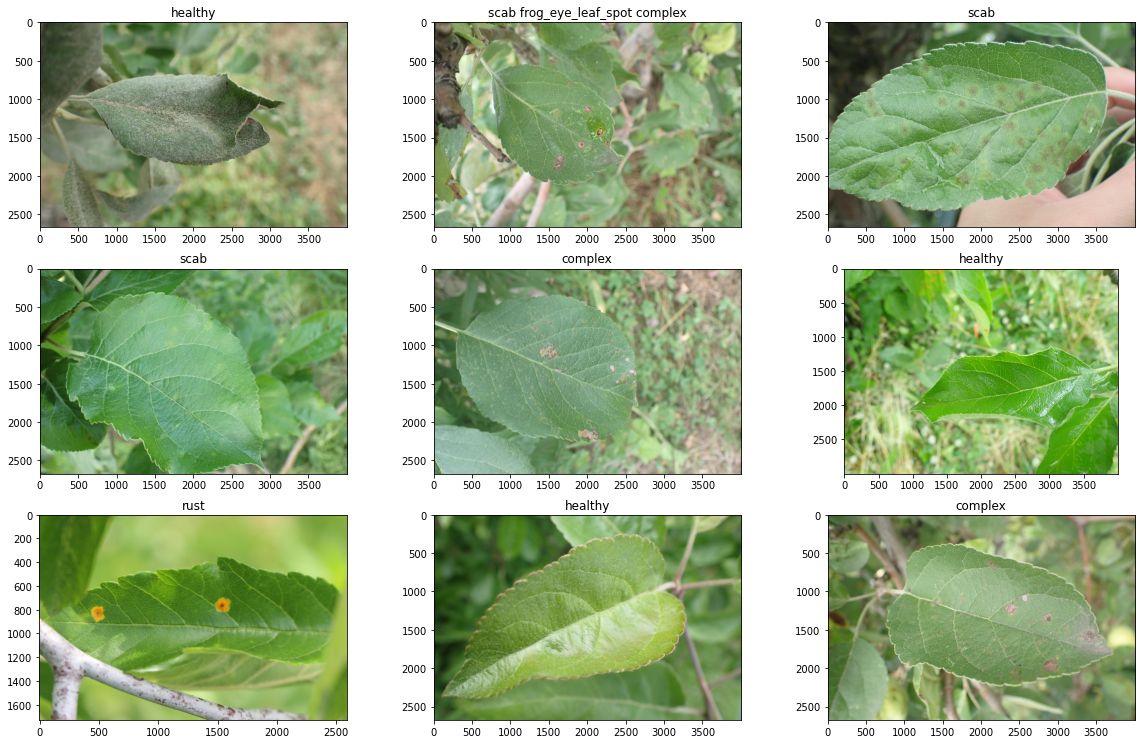

In [4]:
train_path="../input/plant-pathology-2021-fgvc8/train_images"
plt.figure(figsize=(20,40))
i=1
for idx,s in df.head(9).iterrows():
    img_path = os.path.join(train_path,s['image'])
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    fig=plt.subplot(9,3,i)
    fig.imshow(img)
    fig.set_title(s['labels'])
    i+=1

Since each leaves may have more than one disease(e.g.the second leaf in the above image is *scab,frog_eye_leaf_spot,complex*), so it can be a ***multilabel classification***.

In [5]:
df['labels'].unique()
# 1.healthy
# 2.scab
# 3.complex
# 4.rust
# 5.fog_eye_leaf_spot
# 6.powdery_mildew

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

In [6]:
df['labels']=df['labels'].apply( lambda string: string.split(' ') )
df.head()

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
hot_labels = mlb.fit_transform(df['labels'])
print(mlb.classes_)
print(hot_labels)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']
[[0 0 1 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 0 0 1]
 ...
 [0 0 0 0 1 0]
 [0 1 0 0 0 1]
 [0 0 1 0 0 0]]


In [8]:
df_labels = pd.DataFrame(hot_labels,columns=mlb.classes_,index=df.index)
df_labels

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0,0,1,0,0,0
1,1,1,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0
...,...,...,...,...,...,...
18627,0,0,1,0,0,0
18628,0,0,0,0,0,1
18629,0,0,0,0,1,0
18630,0,1,0,0,0,1


<AxesSubplot:>

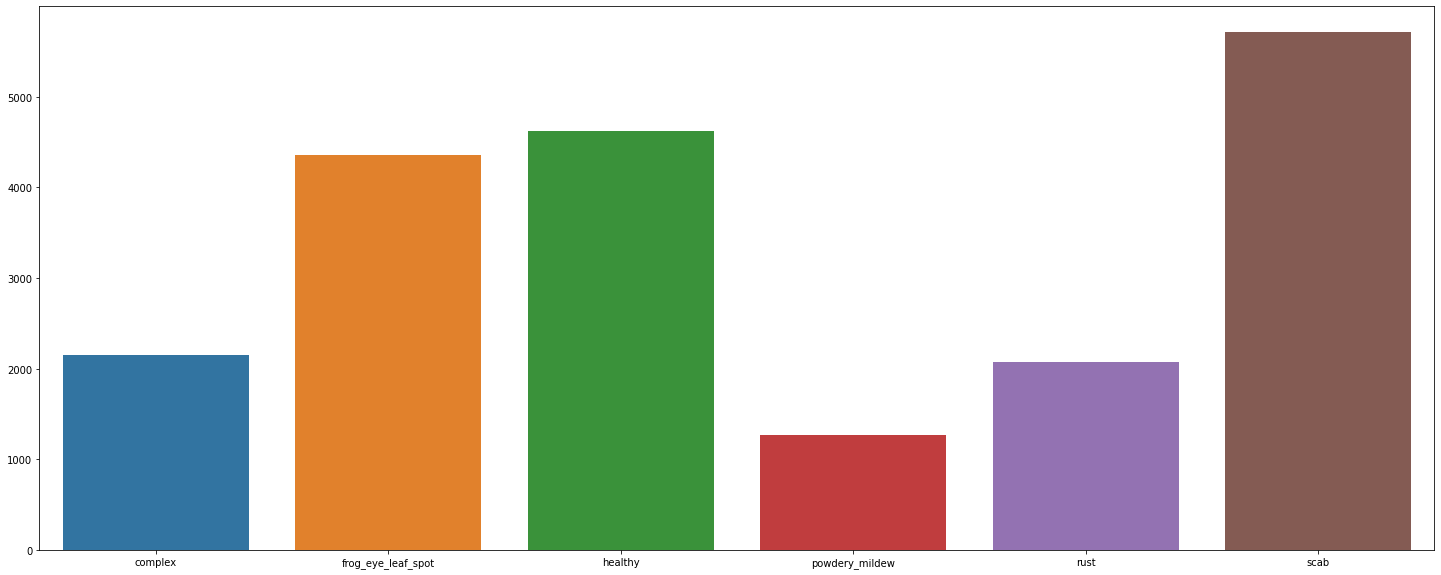

In [9]:
plt.figure(figsize=(25,10))
sns.barplot(x=df_labels.columns,y=df_labels.sum().values)

# *Data Augmentation*

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df,
    directory='../input/resized-plant2021/img_sz_256',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )
#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    df,
    directory='../input/resized-plant2021/img_sz_256',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

Found 14906 validated image filenames belonging to 6 classes.
Found 3726 validated image filenames belonging to 6 classes.


# *Transfer Learning: DenseNet 169*

In [11]:
from keras.applications import InceptionResNetV2
from keras.applications import MobileNetV2
from keras.applications import DenseNet121
from keras.applications import DenseNet169

import keras
from keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

weight_path='../input/tf-keras-pretrained-model-weights/No Top/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model=DenseNet169(weights=weight_path,include_top=False, input_shape=(224,224,3))
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(64,activation='relu')(x)
predictions=Dense(6,activation='sigmoid')(x)

model=Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable=False


trian the last few layers and the ouput layers first

In [12]:
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
es=EarlyStopping(patience=4,monitor=f1,mode='max',restore_best_weights=True)
hist = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    steps_per_epoch=train_generator.samples//128,
                    validation_steps=valid_generator.samples//128,
                    callbacks=[es])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
116/116 [==============================] - 97s 727ms/step - loss: 0.4483 - accuracy: 0.3493 - f1_score: 0.2730 - val_loss: 0.3080 - val_accuracy: 0.5948 - val_f1_score: 0.5238
Epoch 2/20
116/116 [==============================] - 74s 641ms/step - loss: 0.3192 - accuracy: 0.5858 - f1_score: 0.5478 - val_loss: 0.2650 - val_accuracy: 0.6584 - val_f1_score: 0.5701
Epoch 3/20
116/116 [==============================] - 69s 597ms/step - loss: 0.2951 - accuracy: 0.6182 - f1_score: 0.5740 - val_loss: 0.2615 - val_accuracy: 0.6778 - val_f1_score: 0.6388
Epoch 4/20
116/116 [==============================] - 66s 566ms/step - loss: 0.2588 - accuracy: 0.6762 - f1_score: 0.6453 - val_loss: 0.2513 - val_accuracy: 0.6950 - val_f1_score: 0.6844
Epoch 5/20
116/116 [==============================] - 61s 525ms/step - loss: 0.2508 - accuracy: 0.7001 - f1_score: 0.6711 - val_loss: 0.2328 - val_accuracy: 0.6918 - val_f1_score: 0.6702
Epoch 6/20
116/116 [==============================] - 59s 513ms/s

freeze the trained layers, then train the second and the third dense block in DenseNet169

In [ ]:
#the third dense block:
# model.layers[143:595]

In [13]:
model.layers[595:]

In [15]:
for layer in model.layers[:595]:
    layer.trainable=False

for layer in model.layers[143:]:
    layer.trainable=True

for layer in model.layers[595:]:
    layer.trainable=False

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=15,
                    steps_per_epoch=train_generator.samples//128,
                    validation_steps=valid_generator.samples//128,
                    callbacks=[es])

Epoch 1/15
116/116 [==============================] - 71s 491ms/step - loss: 0.1428 - accuracy: 0.8643 - f1_score: 0.8385 - val_loss: 0.6989 - val_accuracy: 0.5119 - val_f1_score: 0.4634
Epoch 2/15
116/116 [==============================] - 54s 464ms/step - loss: 0.1280 - accuracy: 0.8730 - f1_score: 0.8470 - val_loss: 0.1650 - val_accuracy: 0.8147 - val_f1_score: 0.7751
Epoch 3/15
116/116 [==============================] - 54s 461ms/step - loss: 0.1193 - accuracy: 0.8769 - f1_score: 0.8463 - val_loss: 0.2412 - val_accuracy: 0.7468 - val_f1_score: 0.7195
Epoch 4/15
116/116 [==============================] - 54s 464ms/step - loss: 0.1299 - accuracy: 0.8651 - f1_score: 0.8345 - val_loss: 0.1837 - val_accuracy: 0.8093 - val_f1_score: 0.7730
Epoch 5/15
116/116 [==============================] - 55s 473ms/step - loss: 0.1144 - accuracy: 0.8793 - f1_score: 0.8484 - val_loss: 0.1506 - val_accuracy: 0.8513 - val_f1_score: 0.8300
Epoch 6/15
116/116 [==============================] - 55s 473ms/s

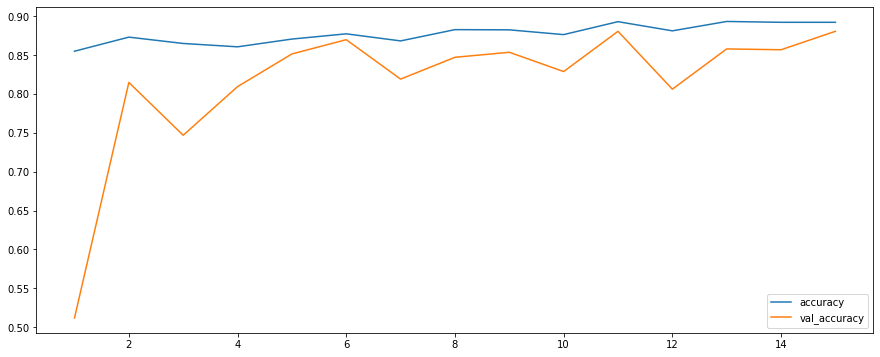

In [16]:
# accuracy
plt.figure(figsize=(15,6))
epoch_list = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epoch_list, history.history['accuracy'],label='accuracy')
plt.plot(epoch_list, history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

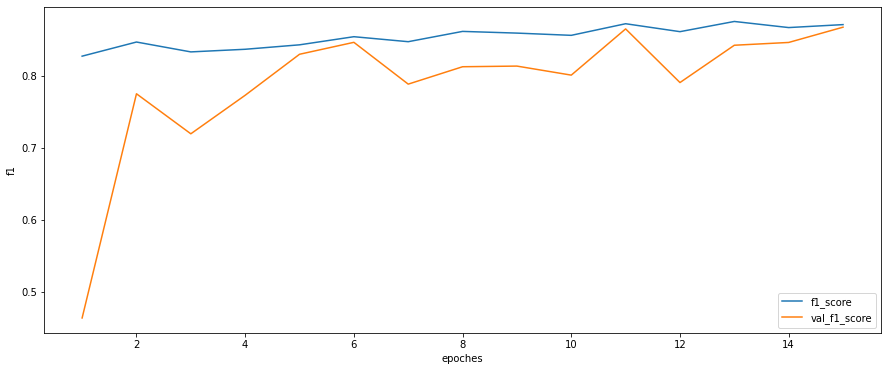

In [17]:
# f1  score
plt.figure(figsize=(15,6))
epoch__list = list(range(1,len(history.history['f1_score'])+1))
plt.plot(epoch__list, history.history['f1_score'],label='f1_score')
plt.plot(epoch__list, history.history['val_f1_score'],label='val_f1_score')
plt.xlabel('epoches')
plt.ylabel('f1')
plt.legend()
plt.show()

In [ ]:
#model.save('plant_incepresnetv2.h5')

# *Prediction*

In [18]:
test_path="../input/plant-pathology-2021-fgvc8/sample_submission.csv"
test = pd.read_csv(test_path)
test

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [19]:
test_data = datagen.flow_from_dataframe(
    test,
    directory='../input/plant-pathology-2021-fgvc8/test_images',
    x_col='image',
    y_col=None,
    color_mode='rgb',
    target_size=(224,224),
    class_mode=None,
    shuffle=False
)
predictions = model.predict(test_data)
print(predictions)

class_idx=[]
for pred in predictions:
    pred=list(pred)
    temp=[]
    for i in pred:
        if (i>0.4):
            temp.append(pred.index(i))
    if (temp!=[]):
        class_idx.append(temp)
    else:
        temp.append(np.argmax(pred))
        class_idx.append(temp)
print(class_idx)

Found 3 validated image filenames.
[[6.8528229e-01 1.4711279e-01 3.7950885e-03 3.5082075e-01 2.9356964e-02
  2.4898031e-01]
 [8.8822740e-01 2.3922630e-01 6.2640385e-07 1.1025424e-03 3.2145262e-03
  1.4302363e-01]
 [5.0805777e-01 5.5547255e-01 1.2409763e-03 1.4032526e-02 1.0355185e-02
  3.4308141e-01]]
[[0], [0], [0, 1]]


In [20]:
class_dict = train_generator.class_indices
def get_key(val):
    for key,value in class_dict.items():
        if (val==value):
            return key
print(class_dict)

sub_pred=[]
for img_ in class_idx:
    img_pred=[]
    for i in img_:
        img_pred.append(get_key(i))
    sub_pred.append( ' '.join(img_pred))
print(sub_pred)

{'complex': 0, 'frog_eye_leaf_spot': 1, 'healthy': 2, 'powdery_mildew': 3, 'rust': 4, 'scab': 5}
['complex', 'complex', 'complex frog_eye_leaf_spot']


# *Submission*

In [21]:
sub = test[['image']]
sub['labels']=sub_pred
sub

,image,labels
0,85f8cb619c66b863.jpg,complex
1,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,complex frog_eye_leaf_spot


In [22]:
sub.to_csv('submission.csv',index=False)